In [1]:
!nvidia-smi

Fri Mar  1 05:44:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000               On  | 00000000:03:00.0 Off |                  Off |
| 41%   38C    P8              14W / 140W |      1MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# !pip install -q --upgrade transformers diffusers ftfy huggingface_hub
# !pip install -q accelerate
# !pip install -q datasets
# !pip install -q pytorch-lightning
# !pip install -q einops
# !pip install -q gradio
# !pip install -q open_clip_torch
# !pip install -q --upgrade omegaconf
# !pip install -q opencv-contrib-python
# !pip install -q controlnet_aux
# !pip install -q invisible-watermark>=0.1.5
# !pip install -q kornia==0.6
# !pip install -qq fastai

In [3]:
from __future__ import print_function
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR
import os
from PIL import Image
import numpy as np
import random
import math
from tqdm import tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from base64 import b64encode
import numpy as np
import json
import cv2
from diffusers import UNet2DModel, AutoencoderKL, UNet2DConditionModel
from diffusers import DiffusionPipeline, StableDiffusionInpaintPipeline, DDPMPipeline
from diffusers import LMSDiscreteScheduler, DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import subprocess

# For video display:
from IPython.display import HTML
from pathlib import Path
from torch import autocast
from torchvision import transforms as tfms
from transformers import logging, CLIPTextModel, CLIPTokenizer
from fastai.basics import show_image,show_images
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

# torch.manual_seed(1)

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

from huggingface_hub import hf_hub_download
from huggingface_hub import notebook_login
from dataclasses import dataclass
from datasets import load_dataset
import pytorch_lightning as pl
# from google.colab.patches import cv2_imshow
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
notebook_login()

In [6]:
# This zip file has 4 folders 'Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones'
from zipfile import ZipFile
with ZipFile('/ThumbnailData.zip', mode='r') as input:
    input.extractall('.')

In [11]:
def prepare_data(root, classes):
    finaldata = []
    for i in range(len(classes)):
        path = root + '/' + classes[i] + '/'
        data_rec = [(path+file_name, i) for file_name in os.listdir(path)]
        finaldata.extend(data_rec)
    random.shuffle(finaldata)
    return finaldata

In [7]:
# !rm -rf '/content/Data/Flying Birds'
!rm -rf '/Data/Large QuadCopters'
!rm -rf '/Data/Winged Drones'
# !mkdir '/content/Data/Flying Birds'
!mkdir '/Data/Large QuadCopters'
!mkdir '/Data/Winged Drones'

In [9]:
!ls '/Data/Flying Birds' | wc -l
!ls '/Data/Small QuadCopters' | wc -l
!ls '/Data/Large QuadCopters' | wc -l
!ls '/Data/Winged Drones' | wc -l

7574
2823
0
0


In [12]:
# class_names = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
class_names = ['Flying Birds','Small QuadCopters']
dataset = prepare_data('/Data',class_names)
print(f'Dataset Length:{len(dataset)}, Train Data length: {int(len(dataset))}')
train_len = int(len(dataset))

Dataset Length:10397, Train Data length: 10397


In [13]:
def generate_image_mask_pil(img):
    # read the image
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # get the dimensions of the image
    height, width, _ = img.shape

    # calculate the desired patch area
    patch_area = 0.05 * height * width

    # generate random position for the patch
    x = np.random.randint(0, width)
    y = np.random.randint(0, height)

    # generate random number of vertices for the patch
    num_vertices = np.random.randint(3, 7)

    # generate random vertices for the patch until the patch area is reached
    vertices = []
    current_area = 0
    while current_area < 0.05 * patch_area:
        vertex_x = np.random.randint(0, width)
        vertex_y = np.random.randint(0, height)
        vertices.append((vertex_x, vertex_y))
        current_area = cv2.contourArea(np.array(vertices))
    vertices = vertices[:-1]
    # create a white patch image with the same shape as the original image
    patch = np.zeros_like(img)
    cv2.fillPoly(patch, [np.array(vertices)], (255, 255, 255))

    # add the white patch to the image
    img = cv2.add(img, patch)
    # img[img == 255] = 0

    # create a binary mask of the modified image
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(vertices)], 255)

    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    mask_pil = Image.fromarray(mask)
    return img_pil, mask_pil

In [14]:
class Customdataset(Dataset):
    def __init__(self, data, transform=None):
        self.images, self.labels     = zip(*data)
        self.transform               = transform

    def __len__(self):
        return len(self.images)

    # Whenever we refer index from main ipynb file __getitem__ dunder method will get invoked. Also index parameter below will be a list when we are calling as batches.

    def __getitem__(self,index):
        if torch.is_tensor(index):
          index = index.tolist()

        orig_image = Image.open(self.images[index])
        masked_image, mask =  generate_image_mask_pil(orig_image)
        if self.transform:
          orig_image = self.transform(orig_image)
          masked_image = self.transform(masked_image)
          mask = self.transform(mask)

        return orig_image, masked_image, mask

In [15]:
# define transform to convert images to PyTorch tensors
train_transforms = tfms.Compose([
    tfms.Resize((128, 128)),
    tfms.ToTensor()
])

channel_means  = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)

train = Customdataset(dataset[:train_len],train_transforms)
train_dataloader  = DataLoader(train, batch_size = 16,shuffle = True, pin_memory = True)
dataiter = iter(train_dataloader)

In [16]:
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  # for i in range(img.shape[0]):
  #   img[i] = (img[i]*channel_stdevs[i]) + channel_means[i]
  return np.transpose(img, (1,2,0))

To check images come out correctly as batches, images.shape: torch.Size([16, 3, 128, 128])


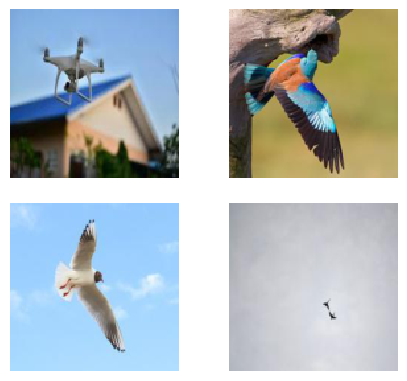

In [17]:
orig_images, masked_images, masks = next(dataiter)
print(f'To check images come out correctly as batches, images.shape: {orig_images.shape}')
num_classes = len(class_names)
r, c = 2, 2
fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    plt.axis('off')
    ax.imshow(unnormalize(orig_images[idx]), interpolation ='none')
plt.show()

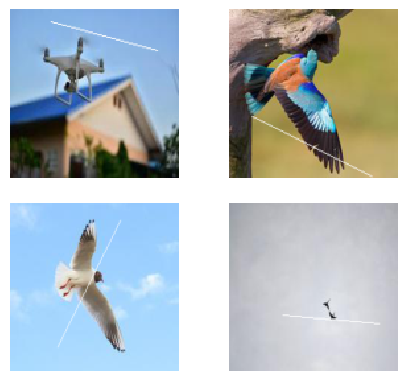

In [18]:
fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    plt.axis('off')
    ax.imshow(unnormalize(masked_images[idx]), interpolation ='none')
plt.show()

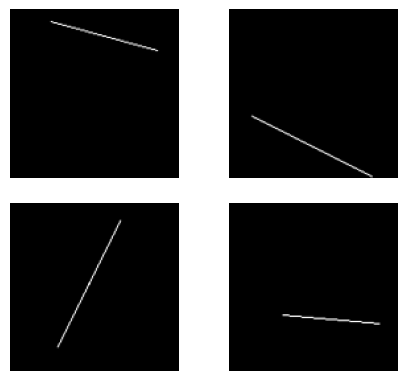

In [19]:
fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    plt.axis('off')
    ax.imshow(masks[idx].squeeze(0), cmap='gray')
plt.show()

In [20]:
@dataclass
class TrainingConfig:
    train_batch_size = 16
    eval_batch_size = 4  # how many images to sample during evaluation
    num_epochs = 1
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 5
    mixed_precision = "no"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "flying_objects"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [21]:
def encode_image_to_latents(imgs):
    # if not isinstance(imgs, list):
    #     imgs = [imgs]

    # img_arr = np.stack([np.array(img) for img in imgs], axis = 0)
    # img_arr = img_arr / 255.0
    # img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
    for img in imgs:
        img_arr = 2 * (img - 0.5)

    latent_dists = vae.encode(imgs.to(device)).latent_dist.sample()
    latent_samples = latent_dists
    latent_samples *= vae.config.scaling_factor

    return latent_samples

def decode_latents_to_img(latents):
    latents = 1 / vae.config.scaling_factor * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    # images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [22]:
# Creating vae for encoding and decoding the latents

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
vae.to(device)
print('Added vae to cuda - vae.config.latent_channels : {vae.config.latent_channels} in_channels : {vae.config.in_channels}')

# Creating noise_scheduler for denoising

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Creating UNet2DConditionModel based on config of pretrained model

model_name = "stabilityai/stable-diffusion-2-inpainting"
# model_name = "runwayml/stable-diffusion-inpainting"
inpainting_unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
model = UNet2DConditionModel.from_config(inpainting_unet.config)
print(f'model.config.in_channels : {model.config.in_channels}, model.config.out_channels : {model.config.out_channels}')

# Creating text_encoder and tokenizer

text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
text_encoder.to(device)
print(f'moved text encoder to {device}')
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

# Same prompt will be used throughout the training loop. Generating text_embedding for the same

prompt = "same background"
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]           # [1, 77, 768]
print(f'text_embeddings.shape before padding : {text_embeddings.shape}')

# Changing the shape to [1, 77, 1024] to avoide error in Unet
padding = 1024 - 768
text_embeddings = F.pad(text_embeddings, (0, padding))                           # [1, 77, 1024]
print(f'text_embeddings.shape after padding : {text_embeddings.shape}')

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Added vae to cuda - vae.config.latent_channels : {vae.config.latent_channels} in_channels : {vae.config.in_channels}


unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

model.config.in_channels : 9, model.config.out_channels : 4


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

moved text encoder to cuda


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

text_embeddings.shape before padding : torch.Size([1, 77, 768])
text_embeddings.shape after padding : torch.Size([1, 77, 1024])


In [23]:
# Creating StableDiffusionInpaintPipeline. Unet of pipeline will be overridden by trained Unet later in evaluation

vae_magic = 0.18215
inpaint = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting",
                                                         revision="fp16",
                                                         torch_dtype=torch.float16).to(device)

model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:270: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [24]:
wt_dir_name = '/'
if os.path.exists(wt_dir_name):
    wt_pth = 'diffusion_pytorch_model.bin'
    state_dict = torch.load(wt_pth)
    inpaint.unet.load_state_dict(state_dict)
    print(f'Unet loaded from {wt_pth}')

Unet loaded from diffusion_pytorch_model.bin


In [25]:
# Creating directory to save eval results
test_dir = os.path.join(config.output_dir, "samples")
os.makedirs(test_dir, exist_ok=True)
print(f'test_dir : {test_dir}')

# Seed and generator for pipeline eval
seed = 17
generator = torch.Generator(device).manual_seed(seed)

# Evaluating with inpaint pipeline and saving the results
def eval_save_image(epoch, eval_orig_imgs, eval_mask_imgs, eval_mask):

    eval_image_lst = []

    for idx, orig_pil_image in enumerate(eval_mask_imgs):

        orig_pil_image = eval_orig_imgs[idx]
        masked_pil_image = eval_mask_imgs[idx]
        pil_mask = eval_mask[idx]

        print(f'starting inpaint - {idx}')
        im_result = inpaint(prompt=['Same Background'],
                            image=masked_pil_image,
                            mask_image=pil_mask,
                            generator=generator).images[0]
        print(f'ending inpaint - {idx}')

        orig_nm = f"{test_dir}/orig_ep{epoch:02d}_{idx}.png"
        mask_img_nm = f"{test_dir}/mask_img_ep{epoch:02d}_{idx}.png"
        pred_nm = f"{test_dir}/pred_ep{epoch:02d}_{idx}.png"
        mask_nm = f"{test_dir}/mask_ep{epoch:02d}_{idx}.png"

        orig_pil_image.save(orig_nm)
        masked_pil_image.save(mask_img_nm)
        im_result.save(pred_nm)
        pil_mask.save(mask_nm)

        tup = (orig_nm, mask_img_nm, pred_nm, mask_nm)
        eval_image_lst.append(tup)

    return eval_image_lst

test_dir : flying_objects/samples


In [26]:
eval_img_txt_path = '/inpaint_eval.txt'
eval_img_path = '/inpaint_eval_images_new2/'
eval_bs = 4
eval_lst = []

def get_eval_image_masks(eval_bs):
    eval_orig_image_list = []
    eval_masked_image_list = []
    eval_mask_list = []
    with open(eval_img_txt_path, 'r') as f:
        eval_img_path_list = f.readlines()

    eval_img_path_list = [item.strip() for item in eval_img_path_list]
    random_idx = random.sample(range(8), eval_bs)
    for idx in random_idx:
        eval_orig_img_name, eval_masked_img_name, eval_mask_name = eval_img_path_list[idx].split(',')
        print(f'get_eval_image_masks : {idx}')
        print(eval_orig_img_name, eval_masked_img_name, eval_mask_name)

        eval_orig_img_path   = eval_img_path + eval_orig_img_name
        eval_masked_img_path = eval_img_path + eval_masked_img_name
        eval_mask_path = eval_img_path + eval_mask_name

        eval_orig_img_pil   = Image.open(eval_orig_img_path)
        eval_masked_img_pil = Image.open(eval_masked_img_path)
        eval_mask_pil = Image.open(eval_mask_path)

        eval_orig_image_list.append(eval_orig_img_pil)
        eval_masked_image_list.append(eval_masked_img_pil)
        eval_mask_list.append(eval_mask_pil)

    return eval_orig_image_list, eval_masked_image_list, eval_mask_list

In [29]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0
    print(f'Training for {config.num_epochs} epochs')

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            orig_train_imgs, masked_train_imgs, train_masks = batch
            orig_image_latent = encode_image_to_latents(orig_train_imgs)
            mask_image_latent = encode_image_to_latents(masked_train_imgs)
            masks_ht_width = [orig_image_latent.shape[-2], orig_image_latent.shape[-1]]
            mask_latent = torch.nn.functional.interpolate(train_masks, size=masks_ht_width)
            orig_image_latent = orig_image_latent.to(device)
            mask_image_latent = mask_image_latent.to(device)
            mask_latent = mask_latent.to(device)

            # Sample noise to add to the images
            noise = torch.randn(orig_image_latent.shape).to(orig_image_latent.device)
            bs = orig_image_latent.shape[0]
            text_embed = text_embeddings.expand(bs, -1, -1)

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=orig_image_latent.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_image_latent = noise_scheduler.add_noise(orig_image_latent, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                input_latent = torch.cat([noisy_image_latent, mask_image_latent, mask_latent], dim=1)
                noise_pred = model(input_latent, timesteps, text_embed, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                state_dict = model.state_dict()
                inpaint.unet.load_state_dict(state_dict)
                print(f'Loaded inpaint.unet with latest trained Unet weights for eval in epoch # {epoch}')
                eval_orig_image_list, eval_masked_image_list, eval_mask_list = get_eval_image_masks(eval_bs)
                eval_image_lst = eval_save_image(epoch, eval_orig_image_list, eval_masked_image_list, eval_mask_list)
                eval_lst.append(eval_image_lst)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)
                print(f'Saved unet with latest trained Unet weights in epoch # {epoch}')

In [30]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:394: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


Training for 1 epochs


  0%|          | 0/650 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 15.73 GiB of which 6.44 MiB is free. Process 1851853 has 15.72 GiB memory in use. Of the allocated memory 15.31 GiB is allocated by PyTorch, and 211.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)